In [1]:
import os,sys
import numpy as np
import copy

codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import nsd_utils, default_paths, coco_utils
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
from model_fitting import initialize_fitting
from plotting_and_analysis import plot_utils 

In [2]:
subject = 1;
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'PCA','S%d_PCA.npy'%subject)
pc_result = np.load(fn2load, allow_pickle=True).item()

scores_each_prf = pc_result['scores']
wts_each_prf = pc_result['wts']
ev_each_prf = pc_result['ev']

In [8]:
# Gather semantic labels for the images (COCO super-categories)
coco_trn, coco_val = coco_utils.init_coco()
cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info(coco_val)
subject_df = nsd_utils.get_subj_df(subject);
all_coco_ids = np.array(subject_df['cocoId'])
ims_each_supcat = []
for sc, scname in enumerate(supcat_names):
    ims_in_supcat = coco_utils.get_ims_in_supcat(coco_trn, coco_val, scname, all_coco_ids)
    ims_each_supcat.append(ims_in_supcat)
ims_each_supcat = np.array(ims_each_supcat)
supcats_each_image = [np.where(ims_each_supcat[:,ii])[0] for ii in range(ims_each_supcat.shape[1])]

# For now, choosing just the images which have only one super-category present.
ims_to_use = [sc for sc in range(len(supcats_each_image)) if len(supcats_each_image[sc])==1]
supcat_labels = np.array([supcats_each_image[sc] for sc in ims_to_use])
n_each_supcat = [np.sum(supcat_labels==sc) for sc in np.unique(supcat_labels)]
print('\nProportion data labels each super-cat:')
print(supcat_names)
print(n_each_supcat)
print(np.sum(n_each_supcat))

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!
loading annotations into memory...
Done (t=16.55s)
creating index...
index created!

Proportion data labels each super-cat:
['accessory', 'animal', 'appliance', 'electronic', 'food', 'furniture', 'indoor', 'kitchen', 'outdoor', 'person', 'sports', 'vehicle']
[37, 1103, 87, 61, 258, 179, 249, 16, 206, 41, 31, 560]
2828


In [87]:
import pandas as pd
labels_file = os.path.join(default_paths.stim_root, 'shared_1000_all_labels_matrix.csv')
labels_df = pd.read_csv(labels_file)
# sort this into order to match my subject's sequence of stimuli
df_inds = [np.where(np.array(labels_df['cocoId'])==all_coco_ids[ii])[0][0] for ii in range(1000)]
labels_df_sorted = labels_df.loc[df_inds]
labels_df_sorted = labels_df_sorted.set_index(np.arange(1000))
assert(np.all(np.array(labels_df_sorted['cocoId'])==all_coco_ids[0:1000]))
labels_df_sorted

,nsdId,cvatId,cocoId,cocoSplit,food_object_card_ratio,food_space_ratio_cmp_objects,food_space_ratio_cmp_image,food_centrality,food_relevance_caption,indoor,...,animal-face,animal-body,food,drink,food-related,faux-food,zoom,reach,large-scale-scene,object
0,2950,1,262145,train2017,0.4375,0.232896,0.045983,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,2990,2,262239,train2017,0.8000,0.385453,0.064550,0,1,1,...,0,0,1,0,1,0,0,0,0,1
2,3049,3,262414,train2017,0.0000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3077,4,524646,train2017,0.0000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,3146,5,262690,train2017,0.0000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,72312,996,515508,train2017,0.0000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
996,72510,997,254130,train2017,0.0000,0.000000,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,1,1
997,72605,998,516634,train2017,0.0000,0.000000,0.000000,0,0,0,...,0,1,0,0,0,0,1,0,0,0
998,72719,999,304627,train2017,0.0000,0.000000,0.000000,0,0,1,...,0,0,0,0,0,0,0,0,1,1


In [88]:
# binary labels for the 16 category attributes
categ_binary = np.array(labels_df_sorted)[:,9:]
categ_binary.shape
categ_names = list(labels_df_sorted.keys())[9:]
print(categ_names)
print(categ_binary.shape)

['indoor', 'outdoor', 'ambiguous-location', 'plant', 'human-face', 'human-body', 'animal-face', 'animal-body', 'food', 'drink', 'food-related', 'faux-food', 'zoom', 'reach', 'large-scale-scene', 'object']
(1000, 16)


In [64]:
def get_description(coco_id):      
    attribute_names = list(labels_df_sorted.keys())[9:]
    
    has_attribute = np.array(labels_df_sorted.loc[ind])[9:]
    description = ['%s'%att for ai, att in enumerate(attribute_names) if has_attribute[ai]]
    return description

In [7]:
# Params for the spatial aspect of the model (possible pRFs)
aperture_rf_range = 1.1
aperture, models = initialize_fitting.get_prf_models(aperture_rf_range=aperture_rf_range)  
n_prfs = models.shape[0]

most extreme RF positions:
[-0.55 -0.55  0.04]
[0.55       0.55       0.40000001]


In [9]:
np.where((np.round(models[:,0],2)==0.00) & (np.round(models[:,1],2)==0.00))
mm = 866
models[mm]

array([0.        , 0.        , 0.28787428])

In [99]:
cocoid

18367

In [106]:
ind = np.where(np.array(labels_df_sorted['cocoId'])==cocoid)[0][0]
ind

103

In [105]:
np.where(np.array(labels_df_sorted['cocoId'])==cocoid)[0][0]

103

543254

Loading images for subject 1

image data size: (10000, 3, 240, 240) , dtype: uint8 , value range: 0 255
105


['outdoor', 'animal-face', 'animal-body', 'zoom']

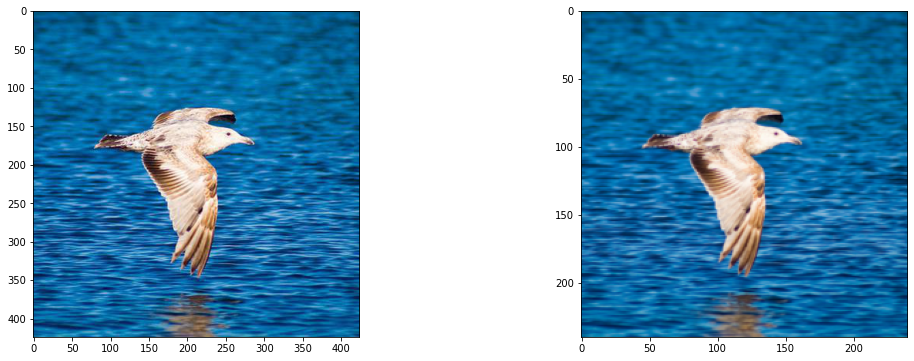

In [111]:
# Double check that the coco labels are correct
imageind = 106
cocoid = np.array(subject_df['cocoId'])[imageind]
print(cocoid)
cocoim = '/lab_data/tarrlab/common/datasets/NSD_images/images/%d.jpg'%cocoid
im = PIL.Image.open(cocoim)

plt.figure(figsize=(18,6));
plt.subplot(1,2,1)
plt.imshow(im)

ims = nsd_utils.get_image_data(subject)
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(ims[imageind,:,:,:],[0,1,2],[2,0,1]))

print(ind)
ind = np.where(np.array(labels_df_sorted['cocoId'])==cocoid)[0][0]
has_attribute = categ_binary[ind,:]
description = ['%s'%att for ai, att in enumerate(attribute_names) if has_attribute[ai]]
description

In [112]:
ims_to_use = np.arange(0,1000)

scores = scores_each_prf[mm][ims_to_use,:]

cc=1
ims_in_cat = np.where(categ_binary[:,cc])[0]
        
meanvals = np.mean(scores[ims_in_cat,:], axis=0)

In [147]:

ims_to_use

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 115, 117, 118, 120, 121,
       122, 123, 124, 126, 127, 128, 129, 130, 131, 132, 134, 136, 137,
       138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       153, 154, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 19

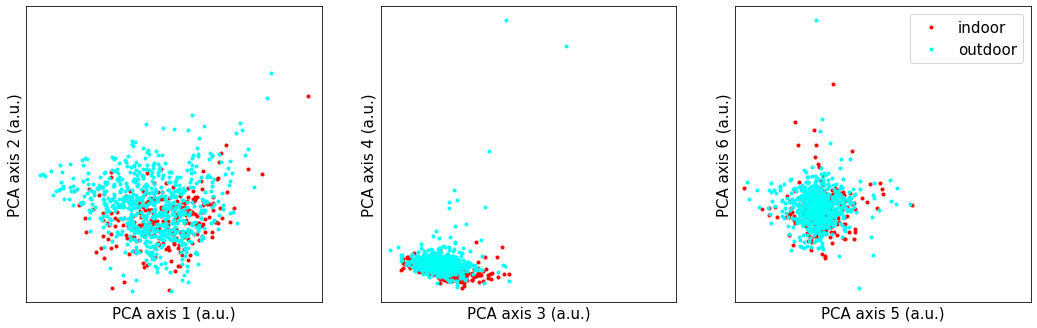

In [150]:
mm = 866

categ_use = [0,1]
ims_to_use = np.where(np.sum(categ_binary[:,categ_use],axis=1)==1)[0]
# ims_to_use = np.arange(0,1000)

scores = scores_each_prf[mm][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(categ_use)+1))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for ci, cc in enumerate(categ_use):

        ims_in_cat = np.where(categ_binary[ims_to_use,cc])[0]
        meanvals = np.mean(scores[ims_in_cat,:], axis=0)
        semvals = np.std(scores[ims_in_cat,:], axis=0)/np.sqrt(np.sum(ims_in_cat))

        h=plt.plot(scores[ims_in_cat,ax2plot[0]], \
                 scores[ims_in_cat,ax2plot[1]],'.',alpha=1,color=colors[cc])

#         h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[cc])
#         plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
#                      yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[cc])
        lh.append(h[0])

    if ai==2:
        plt.legend(handles=lh,labels=[categ_names[cc] for cc in categ_use])
    
    plt.axis('square')
    plt.xlabel('PCA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('PCA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));



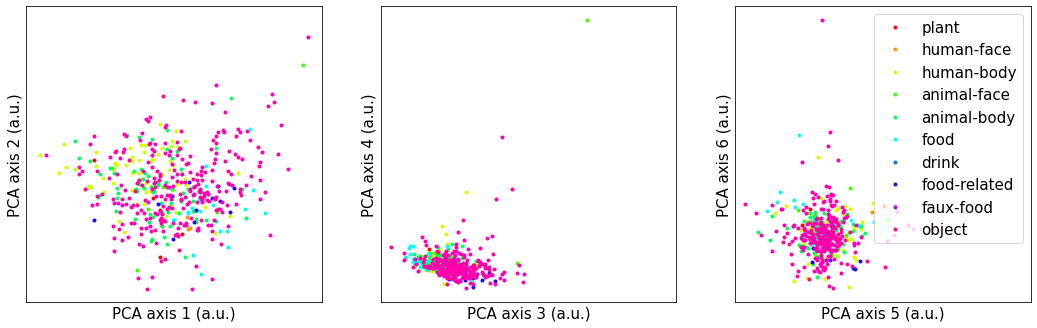

In [151]:
mm = 866

categ_use = list(np.arange(3,12)) + [15]
ims_to_use = np.where(np.sum(categ_binary[:,categ_use],axis=1)==1)[0]

# ims_to_use = np.arange(0,1000)

scores = scores_each_prf[mm][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(categ_use)+1))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for ci, cc in enumerate(categ_use):

        ims_in_cat = np.where(categ_binary[ims_to_use,cc])[0]
        
        nc = np.sum(ims_in_cat)

        if nc>0:
            meanvals = np.mean(scores[ims_in_cat,:], axis=0)
            semvals = np.std(scores[ims_in_cat,:], axis=0)/np.sqrt(nc)
        else:
            meanvals = []
            semvals = []

        h=plt.plot(scores[ims_in_cat,ax2plot[0]], \
                 scores[ims_in_cat,ax2plot[1]],'.',alpha=1,color=colors[ci])
        lh.append(h[0])
        
#         h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[ci])
#         plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
#                      yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[ci])
        

    if ai==2:
        plt.legend(handles=lh,labels=[categ_names[cc] for cc in categ_use])
    
    plt.axis('square')
    plt.xlabel('PCA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('PCA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));



In [154]:
categ_binary[:,categ_use].shape

(1000, 10)

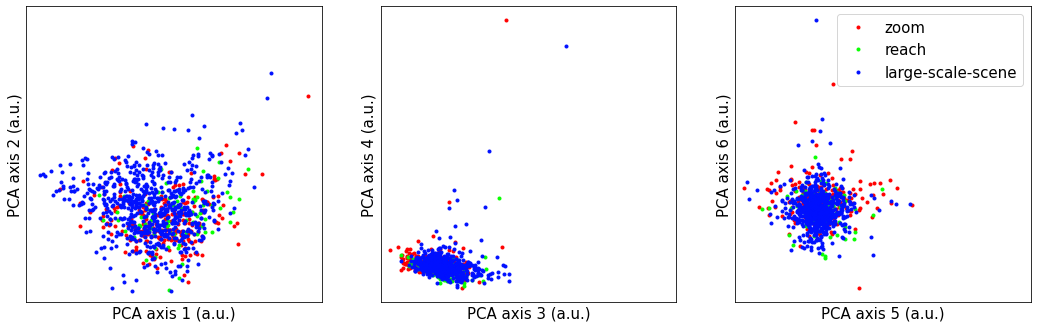

In [155]:
mm = 866

categ_use = np.arange(12,15)
ims_to_use = np.where(np.sum(categ_binary[:,categ_use],axis=1)==1)[0]

# ims_to_use = np.arange(0,1000)

scores = scores_each_prf[mm][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(categ_use)+1))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for ci, cc in enumerate(categ_use):

        ims_in_cat = np.where(categ_binary[ims_to_use,cc])[0]
        
        nc = np.sum(ims_in_cat)

        if nc>0:
            meanvals = np.mean(scores[ims_in_cat,:], axis=0)
            semvals = np.std(scores[ims_in_cat,:], axis=0)/np.sqrt(nc)
        else:
            meanvals = []
            semvals = []

        h=plt.plot(scores[ims_in_cat,ax2plot[0]], \
                 scores[ims_in_cat,ax2plot[1]],'.',alpha=1,color=colors[ci])
        lh.append(h[0])
        
#         h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[ci])
#         plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
#                      yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[ci])
        

    if ai==2:
        plt.legend(handles=lh,labels=[categ_names[cc] for cc in categ_use])
    
    plt.axis('square')
    plt.xlabel('PCA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('PCA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));



In [137]:
categ_names

['indoor',
 'outdoor',
 'ambiguous-location',
 'plant',
 'human-face',
 'human-body',
 'animal-face',
 'animal-body',
 'food',
 'drink',
 'food-related',
 'faux-food',
 'zoom',
 'reach',
 'large-scale-scene',
 'object']

In [156]:
len(ims_to_use)

992

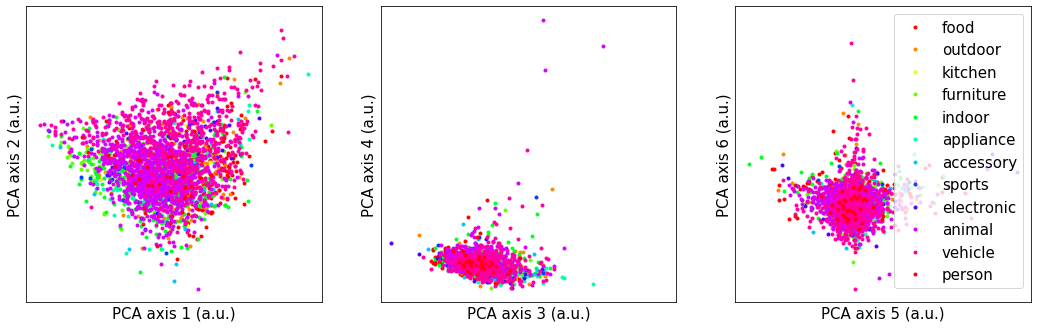

In [13]:
mm = 866

scores = scores_each_prf[mm][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(supcat_names)))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for sc, scname in enumerate(supcat_names):

        ims_in_supcat = (supcat_labels==sc)[:,0]
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))

        h=plt.plot(scores[ims_in_supcat,ax2plot[0]], \
                 scores[ims_in_supcat,ax2plot[1]],'.',alpha=1,color=colors[sc])

#         h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[sc])
#         plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
#                      yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[sc])
        lh.append(h[0])

    if ai==2:
        plt.legend(handles=lh,labels=supcat_names)
    
    plt.axis('square')
    plt.xlabel('PCA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('PCA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));



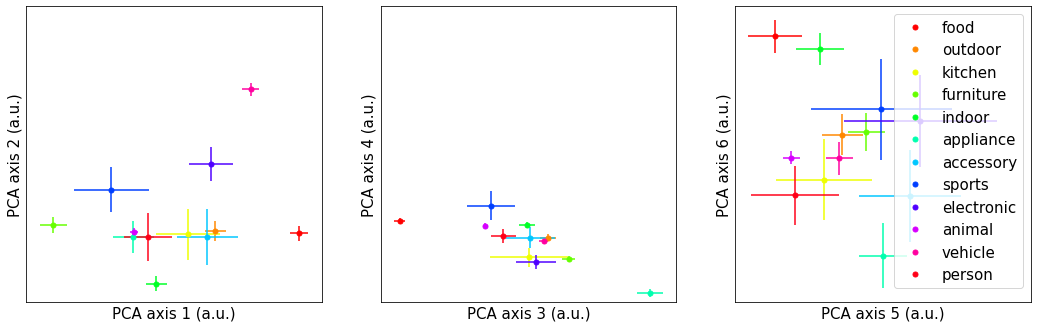

In [14]:
mm = 866

scores = scores_each_prf[mm][ims_to_use,:]

plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(18,6));

ax2plot_list = [[0,1], [2,3], [4,5]]

# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))
colors = cm.hsv(np.linspace(0,1,len(supcat_names)))

for ai, ax2plot in enumerate(ax2plot_list):
    plt.subplot(1,3,ai+1)
    
    lh=[]
    for sc, scname in enumerate(supcat_names):

        ims_in_supcat = (supcat_labels==sc)[:,0]
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))

#         h=plt.plot(scores[ims_in_supcat,ax2plot[0]], \
#                  scores[ims_in_supcat,ax2plot[1]],'.',alpha=1,color=colors[sc])
# 
        h, = plt.plot(meanvals[ax2plot[0]], meanvals[ax2plot[1]],'.',markersize=10,color=colors[sc])
        plt.errorbar(x = meanvals[ax2plot[0]], y = meanvals[ax2plot[1]], \
                     yerr = semvals[ax2plot[1]], xerr = semvals[ax2plot[0]], color=colors[sc])
        lh.append(h)

    if ai==2:
        plt.legend(handles=lh,labels=supcat_names)
    
    plt.axis('square')
    plt.xlabel('PCA axis %d (a.u.)'%(ax2plot[0]+1))
    plt.ylabel('PCA axis %d (a.u.)'%(ax2plot[1]+1))

    plt.xticks([])
    plt.yticks([])

    # plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
    #       %(models[mm,0], models[mm,1], models[mm,2]));

#     plt.title('LDA axes %d and %d'%(ax2plot[0], ax2plot[1]));



In [42]:
# Gather info about which super-categories are present in which images.
ims_each_supcat = []
for sc, scname in enumerate(supcat_names):
    ims_in_supcat = coco_utils.get_ims_in_supcat(coco_trn, coco_val, scname, all_coco_ids)
    ims_each_supcat.append(ims_in_supcat)
    
ims_each_supcat = np.array(ims_each_supcat)
supcats_each_image = [np.where(ims_each_supcat[:,ii])[0] for ii in range(ims_each_supcat.shape[1])]

In [11]:
models[np.array([420, 450, 508, 540, 700, 776, 830, 852, 870])]

array([[-0.15714286, -0.47142857,  0.05557982],
       [-0.15714286, -0.31428571,  0.05557982],
       [-0.31428571,  0.        ,  0.05557982],
       [-0.15714286,  0.15714286,  0.05557982],
       [ 0.44      ,  0.11      ,  0.07722791],
       [ 0.39285714, -0.07857143,  0.10730783],
       [-0.11      ,  0.11      ,  0.14910375],
       [ 0.18333333, -0.18333333,  0.207179  ],
       [ 0.55      ,  0.55      ,  0.28787428]])

In [12]:
np.where(np.logical_and(np.logical_and(np.abs(models[:,0])<0.5,np.abs(models[:,1])<0.5), np.abs(models[:,2])>0.04))

(array([416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428,
        431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443,
        446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458,
        461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473,
        476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488,
        491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503,
        506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518,
        521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533,
        536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548,
        551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
        566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578,
        581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593,
        596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608,
        637, 638, 639, 640, 641, 642, 643, 644, 645

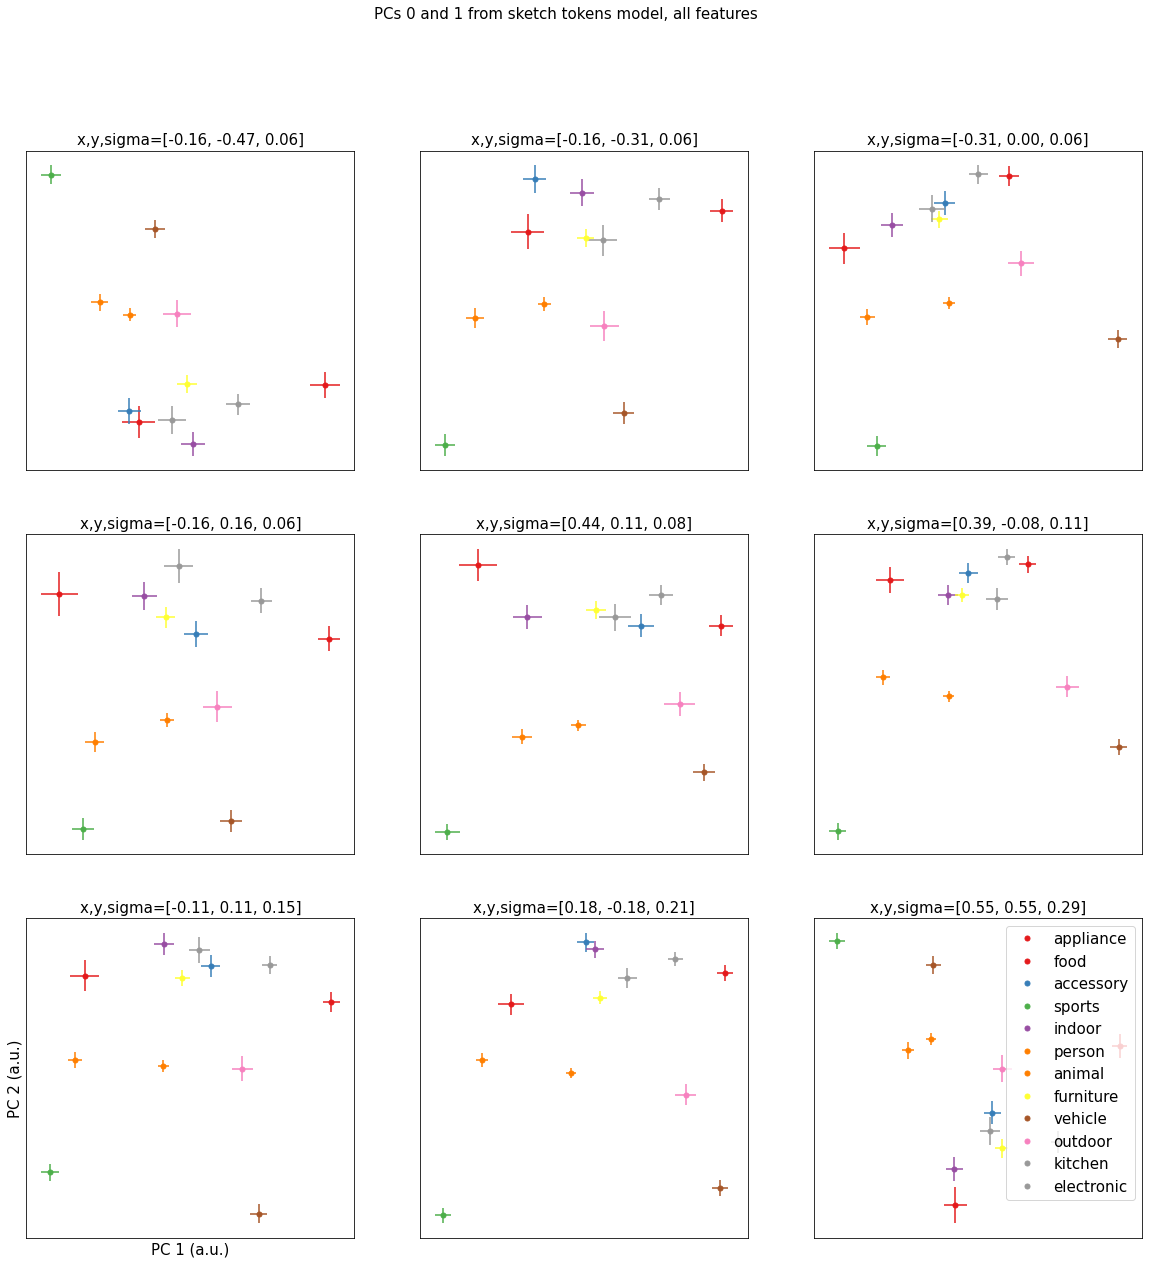

In [13]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(20,20));

pcs2plot = [0,1]
colors = cm.Set1(np.linspace(0,1,len(supcat_names)))

mm2plot = [420, 450, 508, 540, 700, 776, 830, 852, 870]
npx = int(np.ceil(np.sqrt(len(mm2plot))))
npy = int(np.ceil(len(mm2plot)/npx))

for mi, mm in enumerate(mm2plot):
    scores = scores_each_prf[mm]
    plt.subplot(npy,npx,mi+1)
    lh=[]
    for sc, scname in enumerate(supcat_names):
        ims_in_supcat = coco_utils.get_ims_in_supcat(coco_trn, coco_val, scname, all_coco_ids)
        
        meanvals = np.mean(scores[ims_in_supcat,:], axis=0)
        semvals = np.std(scores[ims_in_supcat,:], axis=0)/np.sqrt(np.sum(ims_in_supcat))
        
    #     plt.plot(scores[ims_in_supcat,pcs2plot[0]], scores[ims_in_supcat,pcs2plot[1]],'.',alpha=0.05,color=colors[sc])
        
        h, = plt.plot(meanvals[pcs2plot[0]], meanvals[pcs2plot[1]],'.',markersize=10,color=colors[sc])
        plt.errorbar(x = meanvals[pcs2plot[0]], y = meanvals[pcs2plot[1]], \
                     yerr = semvals[pcs2plot[1]], xerr = semvals[pcs2plot[0]], color=colors[sc])
        lh.append(h)
        
        
    if mi==len(mm2plot)-1:
        plt.legend(handles=lh,labels=supcat_names)
    if mi==len(mm2plot)-npx:
        plt.xlabel('PC %d (a.u.)'%(pcs2plot[0]+1))
        plt.ylabel('PC %d (a.u.)'%(pcs2plot[1]+1))
    
    plt.xticks([])
    plt.yticks([])
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    
plt.suptitle('PCs %d and %d from sketch tokens model, all features\n'%(pcs2plot[0], pcs2plot[1]));
    


Text(0.5, 0.98, 'PCs variance explained from sketch tokens model, all features\n')

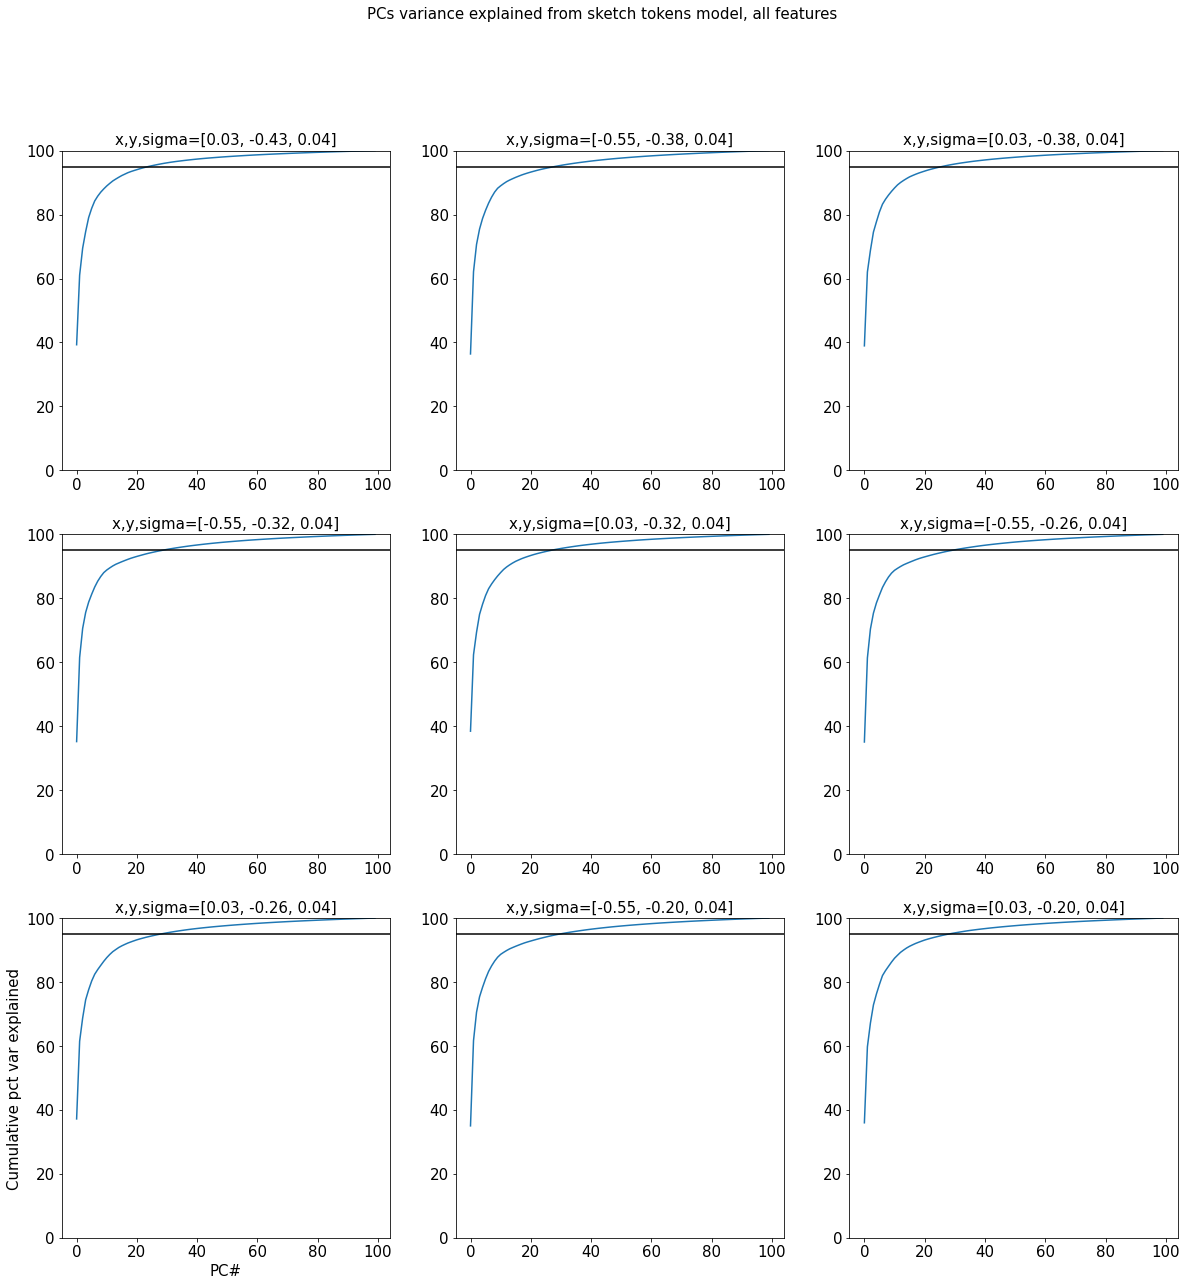

In [14]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(20,20));

# pcs2plot = [0,1]
# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))

mm2plot = np.arange(50,140,10)
npx = int(np.ceil(np.sqrt(len(mm2plot))))
npy = int(np.ceil(len(mm2plot)/npx))

for mi, mm in enumerate(mm2plot):
    ev = ev_each_prf[mm]
    plt.subplot(npx,npy,mi+1)
    
    plt.plot(np.cumsum(ev))
    
    plt.axhline(95,color='k')
    
    if mi==len(mm2plot)-npx:
        plt.xlabel('PC#')
        plt.ylabel('Cumulative pct var explained')
    
#     plt.xticks([])
#     plt.yticks([])
    plt.ylim([0,100])
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    
plt.suptitle('PCs variance explained from sketch tokens model, all features\n')
    

Text(0.5, 0.98, 'PCs wts from sketch tokens model, all features\n')

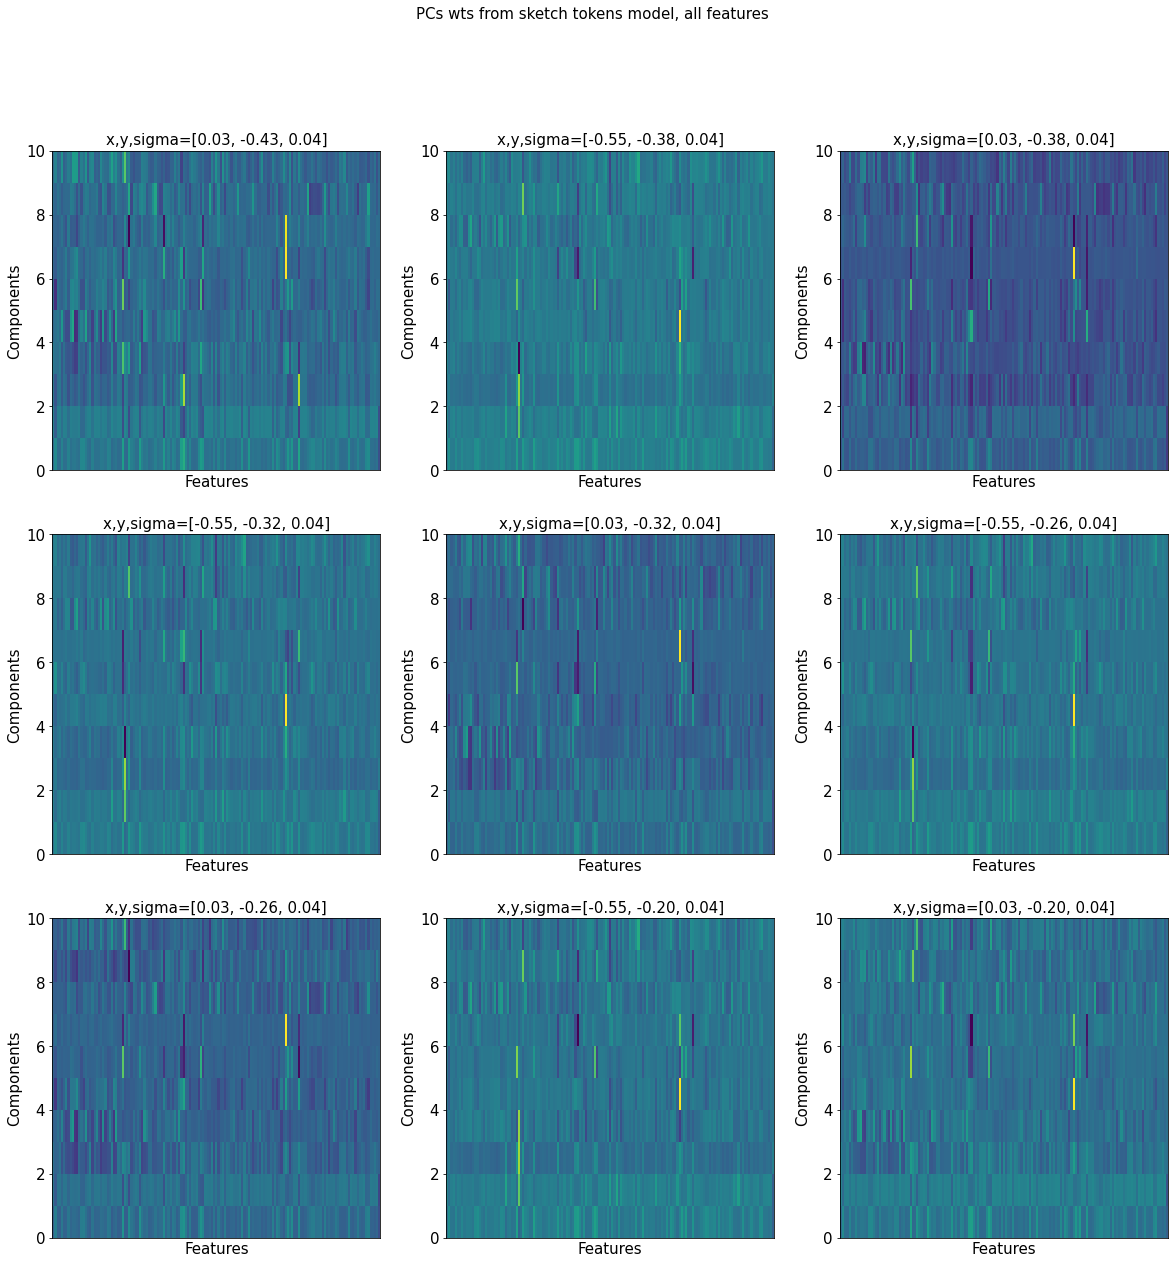

In [15]:
plot_utils.set_all_font_sizes(15)
plt.figure(figsize=(20,20));

# pcs2plot = [0,1]
# colors = cm.Set1(np.linspace(0,1,len(supcat_names)))

mm2plot = np.arange(50,140,10)
npx = int(np.ceil(np.sqrt(len(mm2plot))))
npy = int(np.ceil(len(mm2plot)/npx))

for mi, mm in enumerate(mm2plot):
    wts = wts_each_prf[mm]
    # wts is components x features
    plt.subplot(npx,npy,mi+1)
    
    plt.pcolormesh(wts[0:10,:])
    
#     if mi==len(mm2plot)-npx:
#         plt.xlabel('PC %d (a.u.)'%(pcs2plot[0]+1))
#         plt.ylabel('PC %d (a.u.)'%(pcs2plot[1]+1))
    
    plt.xticks([])
#     plt.yticks([])
    
    plt.ylabel('Components')
    plt.xlabel('Features')
    
    plt.title('x,y,sigma=[%.2f, %.2f, %.2f]'
          %(models[mm,0], models[mm,1], models[mm,2]));
    
plt.suptitle('PCs wts from sketch tokens model, all features\n')
    

In [13]:
best_trf_m.shape

(8, 8)

In [299]:
test_pc_match(w1, w2, up_to_pc=10)

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True]])

In [287]:
w2.shape

(10, 151)

In [43]:
np.argmax(wdot[:,2])

2

Text(0.5, 0.98, 'Comparing PC weights across models: colors are pRF models')

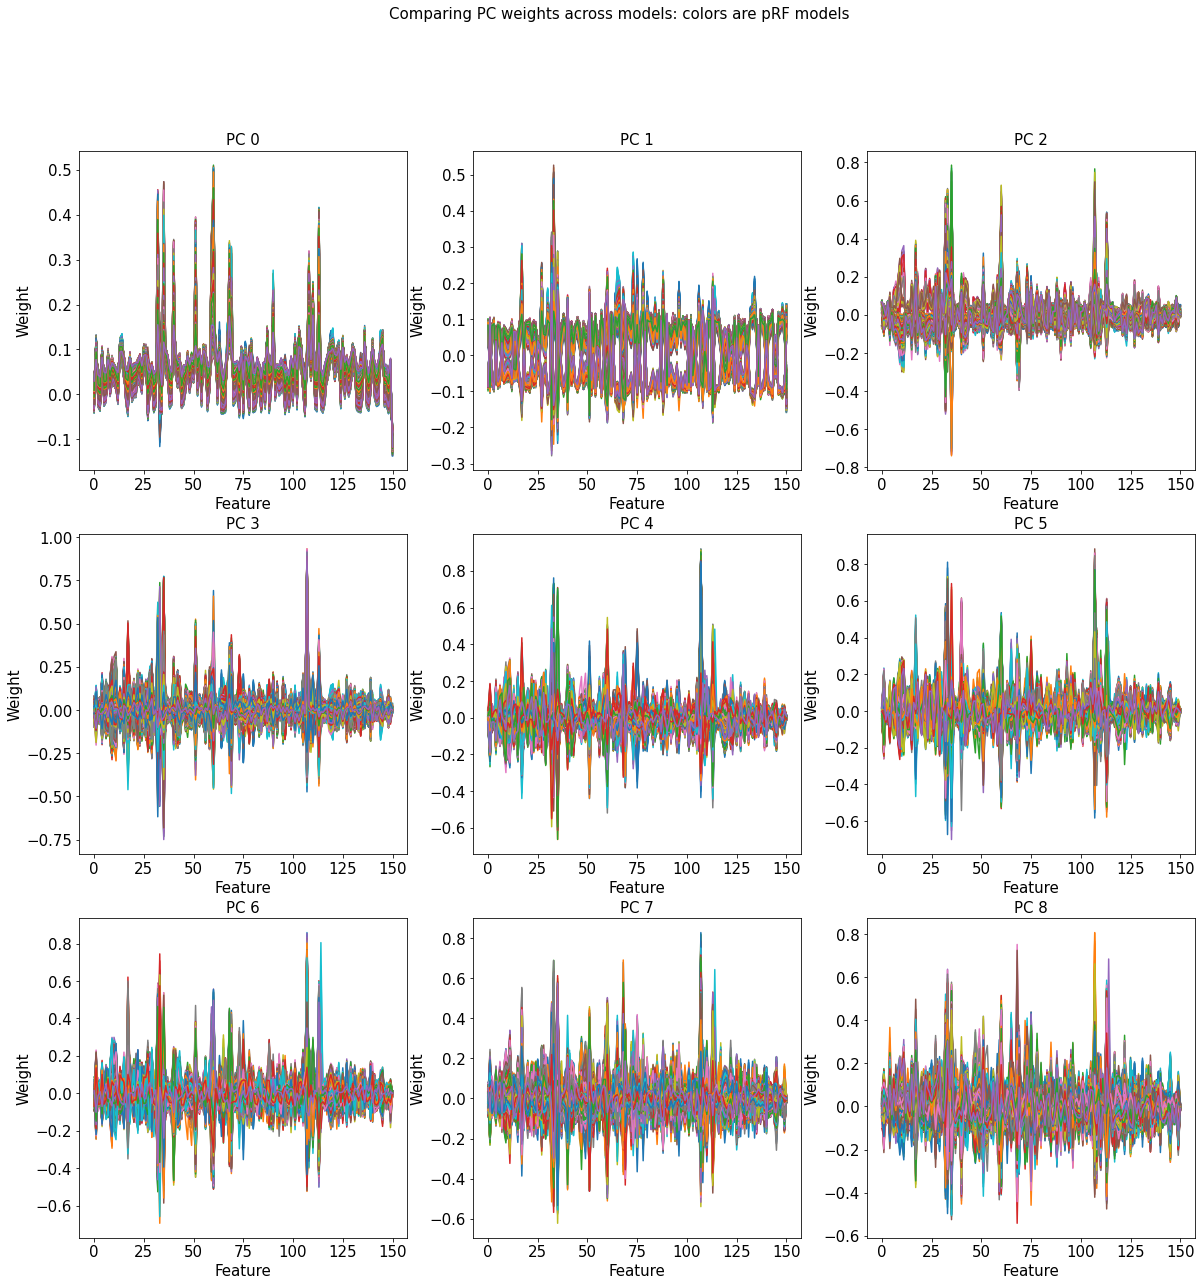

In [16]:
plt.figure(figsize=(20,20));

npx=3;npy=3
for pc in range(9):
    plt.subplot(npx,npy,pc+1)
    w2plot = np.array([wts_each_prf[mm][pc,:] for mm in range(n_prfs)])
    plt.plot(w2plot.T);
    plt.title('PC %d'%pc)
    plt.xlabel('Feature')
    plt.ylabel('Weight')
    
plt.suptitle('Comparing PC weights across models: colors are pRF models')

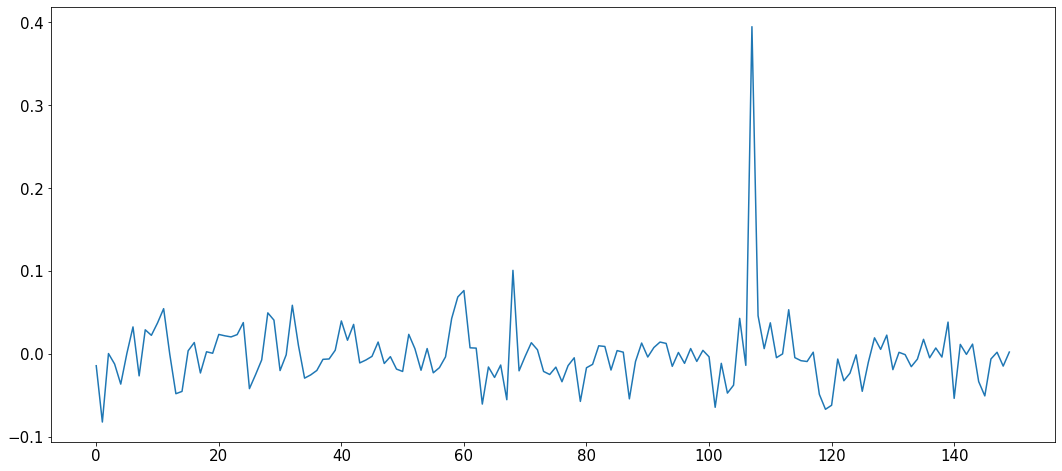

In [128]:
pc=4
w = np.array([wts_each_prf[mm][pc,:] for mm in range(n_prfs)])
wmean = np.mean(w, axis=0)

plt.figure(figsize=(18,8));
plt.plot(wmean)

In [109]:
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
clusters = clust['clusters']['clusters'][0][0]

Text(0.5, 0.98, 'Sketch token features with lowest weights for PC 0')

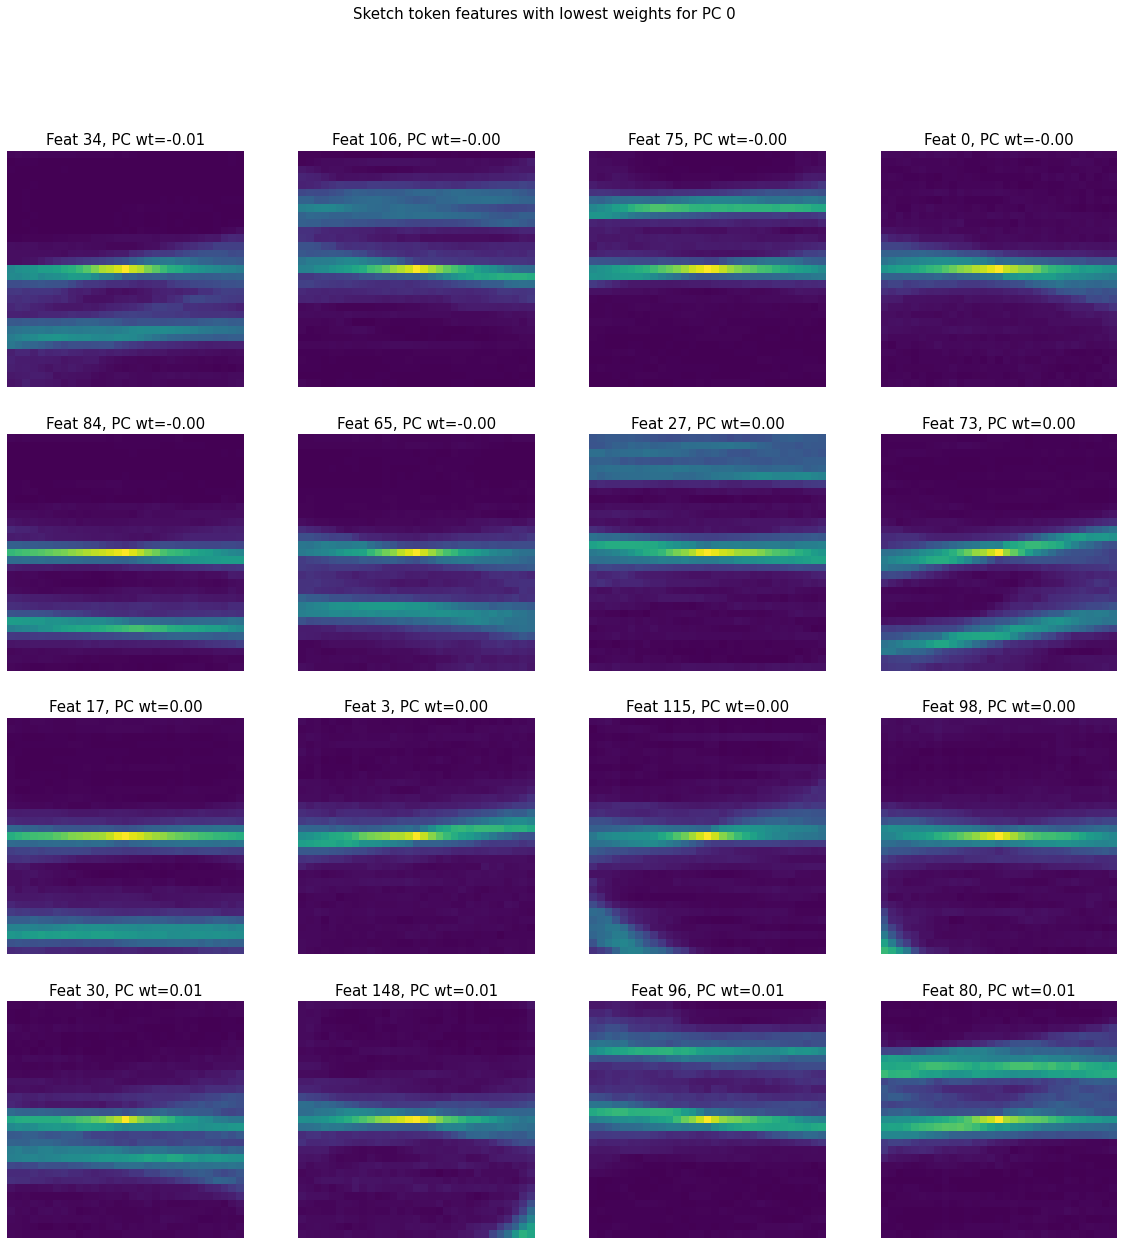

In [152]:
nclusters = clusters.shape[2]
n2plot = 16
# clusters2plot = np.random.choice(np.arange(0,nclusters), n2plot,replace=False)
pc=0
w = np.array([wts_each_prf[mm][pc,:] for mm in range(n_prfs)])
wmean = np.mean(w, axis=0)

clusters2plot = np.flip(np.argsort(wmean))[0:n2plot]
clusters2plot = np.argsort(wmean)[0:n2plot]

plt.figure(figsize=(20,20))
for ci,cc in enumerate(clusters2plot):
    
    plt.subplot(4,4,ci+1)
    plt.pcolormesh(clusters[:,:,cc])
    plt.axis('square')
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title('Feat %d, PC wt=%.2f'%(cc, wmean[cc]))
    
plt.suptitle('Sketch token features with lowest weights for PC %d'%pc)